<a href="https://colab.research.google.com/github/kdidi99/ml_heidelberg/blob/main/ex04a-cross-feedback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from scipy import integrate


import pandas as pd


### Import Data

In [ ]:
digits = load_digits()

data = digits['data']
images = digits['images']
target = digits['target']
target_names = digits['target_names']


<font color='green'><b>
This part is just copied from previous worked solutions, nothing to comment.

## 1.1 Euclidean Distance (7 points)

Use 3rd vectorized method from 1b) 
\begin{equation}
\begin{aligned}
\operatorname{dist}(\mathbf{a}, \mathbf{b}) &=\sqrt{\left(a_{1}-b_{1}\right)^{2}+\left(a_{2}-b_{2}\right)^{2}+\ldots} \\
&=\sqrt{\left(a_{1}^{2}+a_{2}^{2}+\ldots\right)+\left(b_{1}^{2}+b_{2}^{2}+\ldots\right)-\left(2 a_{1} b_{1}+2 a_{2} b_{2}+\ldots\right)} \\
&=\sqrt{\sum_{i} a_{i}^{2}+\sum_{i} b_{i}^{2}-2 \cdot \mathbf{a}^{\top} \cdot \mathbf{b}}
\end{aligned}
\end{equation}

In [ ]:
# old definition for euclidean distance taken from 1b) 
# does not work for 1xN vectors
def dist_vec(X1, X2):
    AB = np.dot(X1, np.transpose(X2))
    AA = np.sum(np.square(X1), axis = 1)
    BB = np.sum(np.square(X2), axis = 1)
    
    dist_matrix = np.sqrt(np.transpose(BB - 2*AB) + AA)
    
    return dist_matrix

In [ ]:
# new definition, returns euclidean distance for any two image data arrays 

def dist_vec2(x1, x2): 
    '''
    returns a single distance for comparing two images
    NxM input works as data is flattened to 1xN vector
    '''
    X1 = x1.flatten()
    X2 = x2.flatten()
    AB = np.dot(X1, np.transpose(X2))
    AA = np.sum(np.square(X1))
    BB = np.sum(np.square(X2))
    
    dist_matrix = np.sqrt(np.transpose(BB - 2*AB) + AA)
    
    return dist_matrix

<font color='green'><b>
In the worked solution the functions are integrated in a 
class and the different calculations are split up in functions 
differently, but lead to almost equal calculations.

1797


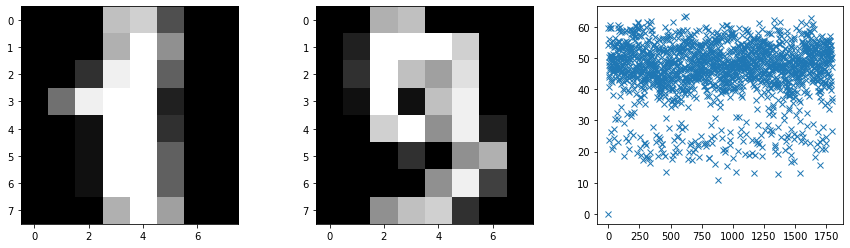

In [ ]:
## some tests 

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

test_im1 = images[1, :, :]
test_im2 = images[9, :, :]

data1 = data[1,:]
ax[0].imshow(test_im1, cmap = 'gray')
ax[1].imshow(test_im2, cmap = 'gray')

dist = dist_vec2(test_im1, test_im2)
#ax[2].imshow(dist, cmap = 'coolwarm_r')

#pd.DataFrame(dist)
l = int(np.shape(images)[0])
print(int(l))
d = []
for i in range(l):
    d.append(dist_vec2(images[0, :, :], images[i, :, :]))
    
ax[2].plot(np.arange(l), d, marker = 'x', linestyle = 'none')

In [ ]:
# because the euclidean norm is symmetric d(x1, x2) = d(x2, x1) 
# only lower trianglular matrix has to be computed 

N = int(np.shape(images)[0])
D = np.zeros((N,N))
for i in range(N):
    for j in range(i):
        D[i,j] = dist_vec2(images[i,:, :], images[j,:,:])
    
D = D + D.T #complete the upper triangle
        

<font color='green'><b>
This method to calculate dissimilarity of the pictures differs from the worked example. The code of this group is not vectorized and therefore probably significantly slower than the worked example.

In [ ]:
#m nearest instances 
N = int(np.shape(images)[0])
m = 5

S = np.zeros((N,m))
for i in range(N):
    S[i] = np.argsort(D[i,...])[0:m] # beware 1st instance = query instance 


print('arg of closest instances in dataset, ranked')
pd.DataFrame(S)

arg of closest instances in dataset, ranked


,0,1,2,3,4
0,0.0,877.0,1365.0,1541.0,1167.0
1,1.0,93.0,1120.0,1112.0,1050.0
2,2.0,57.0,51.0,50.0,115.0
3,3.0,259.0,1498.0,1518.0,475.0
4,4.0,1777.0,100.0,1735.0,1244.0
...,...,...,...,...,...
1792,1792.0,1698.0,815.0,1759.0,1686.0
1793,1793.0,160.0,724.0,1703.0,646.0
1794,1794.0,148.0,248.0,1763.0,242.0
1795,1795.0,254.0,251.0,1792.0,849.0


In [ ]:
#calculate the precision of each classification for a given number of close instances

def get_P(D, target):
    N = len(target)
    S = np.zeros((N,N))
    for i in range(N):
        S[i] = np.argsort(D[i,...]) # beware 1st instance = query instance 
        


def TP_FP_m(D, target, m):
    
    #first generate the ordered similarty list S_NN for all instances
    N = len(target)
    S = np.zeros((N,N))
    for i in range(N):
        S[i] = np.argsort(D[i,...]) # beware 1st instance = query instance 
        
        
    res = np.zeros((N, 6)) #N x (i, label, TP, FP, prec, recall)
    P = np.zeros((N,N))
    R = np.zeros((N,N))
    for m in range(N):
        if m == 0: 
            # write the instance label into first collum
            P[...,0] = target[[np.rint(S[...,0]).astype(int)]] 
            R[...,0] = target[[np.rint(S[...,0]).astype(int)]]
        else:
            for j in S:
                i = j[0:m]
                i0 = int(j[0])
                test_label = target[i0] #label of test instance
                pred_labels = target[[np.rint(i).astype(int)]] #convert each row of S_im into integers and use as index to get labels
                TP = np.count_nonzero(pred_labels == test_label) #TP
                FP = len(i)-TP #FP
                N_i = np.count_nonzero(target == test_label)

                prec = TP/(TP + FP)
                rec = TP/N_i

                res[i0, 2] = TP
                res[i0, 3] = FP
                res[i0, 0] =i[0]
                res[i0, 1] =test_label
                res[i0, 4] = prec
                res[i0, 5] = rec
                P[i0, m] = prec
                R[i0, m] = rec
                
    return res, P, R

test, P, R = TP_FP_m(D, target, N)

/Users/leo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/leo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/leo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result e

<font color='green'><b>
Like the function before, this function is not vectorized and therefore probably significantly slower than the worked example.

### Results P:
The precision matrix P has a final shape of NxN as for all distance comparisons, one is compared to the rest, the first collum contains the label of the compared 

In [ ]:
pd.DataFrame(P[0:15, 0:15])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,1.0,1.0,1.000000,1.00,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000
1,1.0,1.0,1.0,1.000000,1.00,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000
2,2.0,1.0,1.0,1.000000,1.00,1.0,0.833333,0.857143,0.875,0.888889,0.9,0.818182,0.833333,0.769231,0.714286
3,3.0,1.0,1.0,1.000000,1.00,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000
4,4.0,1.0,1.0,1.000000,1.00,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000
5,5.0,1.0,0.5,0.333333,0.25,0.2,0.166667,0.142857,0.125,0.111111,0.1,0.090909,0.083333,0.076923,0.071429
6,6.0,1.0,1.0,1.000000,1.00,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000
7,7.0,1.0,1.0,1.000000,1.00,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000
8,8.0,1.0,1.0,1.000000,1.00,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000
9,9.0,1.0,1.0,1.000000,1.00,1.0,1.000000,1.000000,1.000,1.000000,0.9,0.909091,0.916667,0.923077,0.928571


### Results R:

first  collum again contains instance label. 

In [ ]:
pd.DataFrame(R[0:15, 0:15])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,0.005618,0.011236,0.016854,0.022472,0.028090,0.033708,0.039326,0.044944,0.050562,0.056180,0.061798,0.067416,0.073034,0.078652
1,1.0,0.005495,0.010989,0.016484,0.021978,0.027473,0.032967,0.038462,0.043956,0.049451,0.054945,0.060440,0.065934,0.071429,0.076923
2,2.0,0.005650,0.011299,0.016949,0.022599,0.028249,0.028249,0.033898,0.039548,0.045198,0.050847,0.050847,0.056497,0.056497,0.056497
3,3.0,0.005464,0.010929,0.016393,0.021858,0.027322,0.032787,0.038251,0.043716,0.049180,0.054645,0.060109,0.065574,0.071038,0.076503
4,4.0,0.005525,0.011050,0.016575,0.022099,0.027624,0.033149,0.038674,0.044199,0.049724,0.055249,0.060773,0.066298,0.071823,0.077348
5,5.0,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495
6,6.0,0.005525,0.011050,0.016575,0.022099,0.027624,0.033149,0.038674,0.044199,0.049724,0.055249,0.060773,0.066298,0.071823,0.077348
7,7.0,0.005587,0.011173,0.016760,0.022346,0.027933,0.033520,0.039106,0.044693,0.050279,0.055866,0.061453,0.067039,0.072626,0.078212
8,8.0,0.005747,0.011494,0.017241,0.022989,0.028736,0.034483,0.040230,0.045977,0.051724,0.057471,0.063218,0.068966,0.074713,0.080460
9,9.0,0.005556,0.011111,0.016667,0.022222,0.027778,0.033333,0.038889,0.044444,0.050000,0.050000,0.055556,0.061111,0.066667,0.072222


In [ ]:
### avrg P_k, R_k for label class k

def get_avrg_PR(P, R):
    N = len(target)
    uni = np.unique(P[...,0])
    avrg_P = np.zeros((len(uni), N-1)) # ( ...P_k(m)... ) x k
    avrg_R = np.zeros((len(uni), N-1)) # ( ...P_k(m)... ) x k
    
    for k in uni:
        k_arg = (np.argwhere(P[...,0] == k).flatten()).astype(int) #index of rows with klass k
        #print(k_arg)
        
        #compute average within klass k for m entries, retulting in k x N array (for each m in 1,...,N)
        vals = P[[k_arg], ...][0,:,1:]
        vals_R = R[[k_arg], ...][0,:,1:]
        avrg_P[int(k)] = np.sum(vals, axis = 0)/(len(k_arg))
        avrg_R[int(k)] = np.sum(vals_R, axis = 0)/(len(k_arg))
        
    return avrg_P, avrg_R


P_k, R_k = get_avrg_PR(P, R)

### Results $\bar{P}_k$ and $\bar{R}_k$

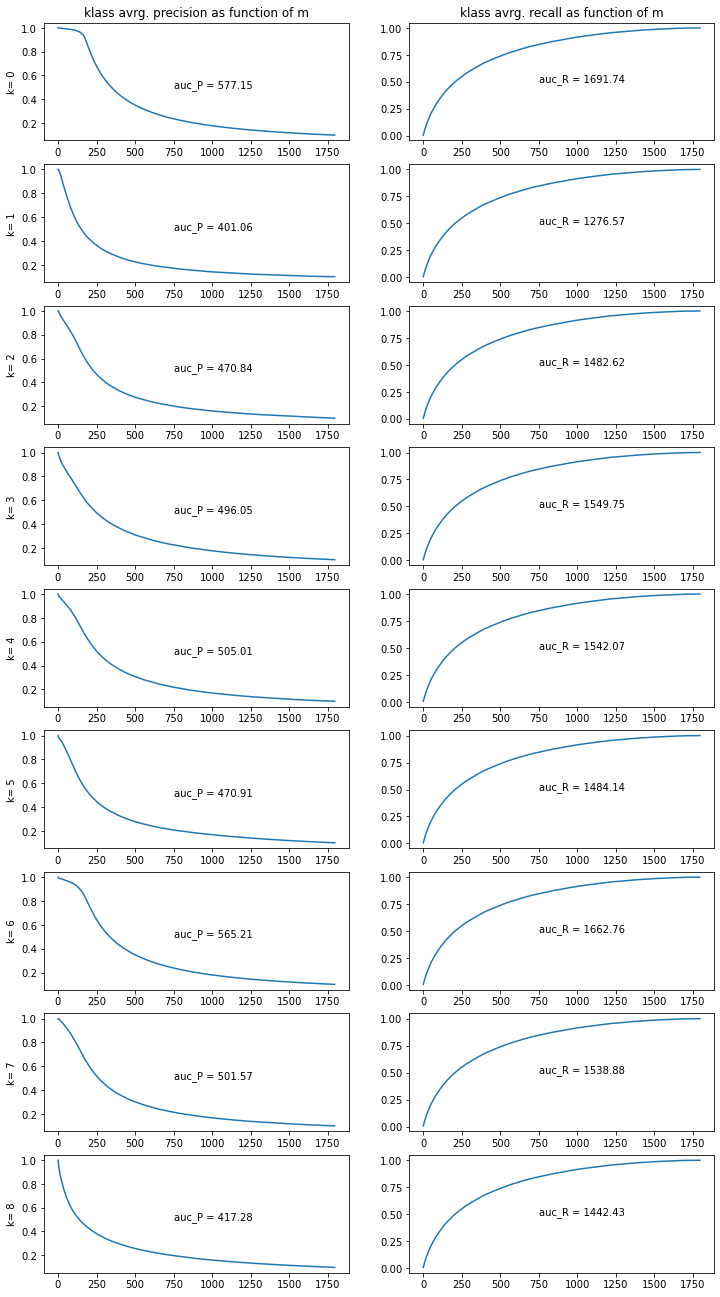

In [ ]:
# P_K

fig, ax = plt.subplots(9, 2, figsize = (12, 23), squeeze='loose')

for i in range(9):
    ax[i, 0].plot(np.arange(len(P_k[i, ...])), P_k[i, ...])
    ax[i, 0].set_ylabel('k= ' + str(i))
    auc_p = np.trapz(P_k[i])
    ax[i,0].annotate('auc_P = '+str(round(auc_p, 2)), xy = (750, 0.5))

for j in range(9):
    ax[j, 1].plot(np.arange(len(R_k[i, ...])), R_k[i, ...])
    auc_r = np.trapz(R_k[j])
    ax[j,1].annotate('auc_R = '+str(round(auc_r, 2)), xy = (750, 0.5))
    
ax[0,0].set_title('klass avrg. precision as function of m')
ax[0,1].set_title('klass avrg. recall as function of m')
plt.show()

<font color='green'><b>
The precision and recall where plotted indipendently, but the task was to visualize the dependence of the two parameters. The AUC was therefore calculated wrongly.
The rest of the solution is missing.